# Решение 1 соревнования по Машинному обучению

In [35]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn_pandas import DataFrameMapper

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import optuna

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

In [13]:
df_train = pd.read_csv('/kaggle/input/mts-teta-compet1/train.csv')
df_test = pd.read_csv('/kaggle/input/mts-teta-compet1/test.csv')

In [3]:
df_train

,client_id,регион,использование,сумма,частота_пополнения,доход,сегмент_arpu,частота,объем_данных,on_net,продукт_1,продукт_2,зона_1,зона_2,mrg_,секретный_скор,pack,pack_freq,binary_target
0,0,Уран,>24LY,14.617797,1.0,27034.974914,71.37,1.000000,NaN,26.0,10.0,NaN,NaN,NaN,False,0.540984,_output-_сеть 500 (условие) 2000f;5d,1.000000,0
1,1,Марс,>24LY,32.686083,3.0,40373.828300,354.27,2.000000,35.679126,45.0,8.0,NaN,NaN,NaN,False,0.573770,тариф_a 250 (условие) _безлим_c_output_сутки,1.414214,0
2,2,Церера,>24LY,25.318570,3.0,32004.378374,139.74,1.414214,NaN,NaN,13.0,NaN,NaN,NaN,False,0.131148,NaN,NaN,0
3,3,Марс,>24LY,70.710678,38.0,59953.505011,1722.65,6.403124,163.309522,203.0,274.0,NaN,NaN,0.031817,False,0.885246,"трафик: 100 (условие) 40mb,_сутки",4.000000,0
4,4,Меркурий,>24LY,9.244999,2.0,21499.998428,28.63,1.414214,5.000000,NaN,NaN,NaN,NaN,NaN,False,0.344262,"трафик: 100 (условие) 40mb,_сутки",1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010243,1010243,Марс,>24LY,73.088166,19.0,57900.865741,1498.72,4.582576,NaN,80.0,258.0,2.0,NaN,NaN,False,0.934426,_output-_сеть 500 (условие) 2000f;5d,4.242641,0
1010244,1010244,Марс,>24LY,20.672445,2.0,32166.158933,142.74,2.645751,NaN,25.0,2.0,5.0,NaN,NaN,False,0.540984,_output-_сеть 500 (условие) 2000f;5d,1.000000,0
1010245,1010245,Земля,>24LY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.049180,NaN,NaN,1
1010246,1010246,Солнце,>24LY,66.986417,10.0,56223.620819,1332.48,4.123106,NaN,62.0,31.0,29.0,NaN,NaN,False,1.000000,_соц_u2opia_weekly,1.000000,0


## Data Preparation

In [4]:
def data_prepare(data):
    data_clean = data.copy()
#     data_clean['зона_1'] = data_clean['зона_1'].fillna(0)
#     data_clean['зона_2'] = data_clean['зона_2'].fillna(0)
    
    
#     data_clean['зона_1_cat'] = data['зона_1'].apply(lambda x: 0 if np.isnan(x) or x==0 else 1)
#     data_clean['зона_2_cat'] = data['зона_2'].apply(lambda x: 0 if np.isnan(x) or x==0 else 1)
    
    pie_vals_dependents = list(zip(data['pack'].value_counts().index, round(data['pack'].value_counts(normalize=True) * 100, 2).values))
    list2replace = [i[0] for i in pie_vals_dependents if i[1]<2]
    data_clean['pack_prepared'] = data['pack'].apply(lambda x: 'others' if x in list2replace or pd.isnull(x) else x)
    
    
    data_clean['использование_prepared'] = data['использование'].apply(lambda x: 1 if x == '>24LY' else 0)
    
    data_clean['регион_prepared'] = data['регион'].apply(lambda x: 'others' if pd.isnull(x) else x)
    
    data_clean['missing_values_count'] = data.isnull().sum(axis=1)
    
#     data_clean['секретный_скор_bin'] = pd.cut(data['секретный_скор'], bins=bins, labels=labels)
    
#     data_clean['nan_in_sum'] = data_clean['сумма'].apply(lambda x: 0 if np.isnan(x) else 1)
    
    return data_clean

In [5]:
clean_data = data_prepare(df_train)

In [6]:
clean_data['pack_prepared'].nunique()

13

In [7]:
clean_data.columns

Index(['client_id', 'регион', 'использование', 'сумма', 'частота_пополнения',
       'доход', 'сегмент_arpu', 'частота', 'объем_данных', 'on_net',
       'продукт_1', 'продукт_2', 'зона_1', 'зона_2', 'mrg_', 'секретный_скор',
       'pack', 'pack_freq', 'binary_target', 'pack_prepared',
       'использование_prepared', 'регион_prepared', 'missing_values_count'],
      dtype='object')

In [8]:
num_cols = [
    'сумма',
    'частота_пополнения',
    'доход',
    'сегмент_arpu',
    'частота',
    'объем_данных',
    'on_net',
    'продукт_1',
    'продукт_2',
    'зона_1',
    'зона_2',
    'секретный_скор',
    'pack_freq',
    'missing_values_count',
]

cat_cols = [
    'регион_prepared',
    'использование_prepared',
    'pack_prepared',
]

feature_cols = num_cols + cat_cols
target_col = 'binary_target'

<Axes: >

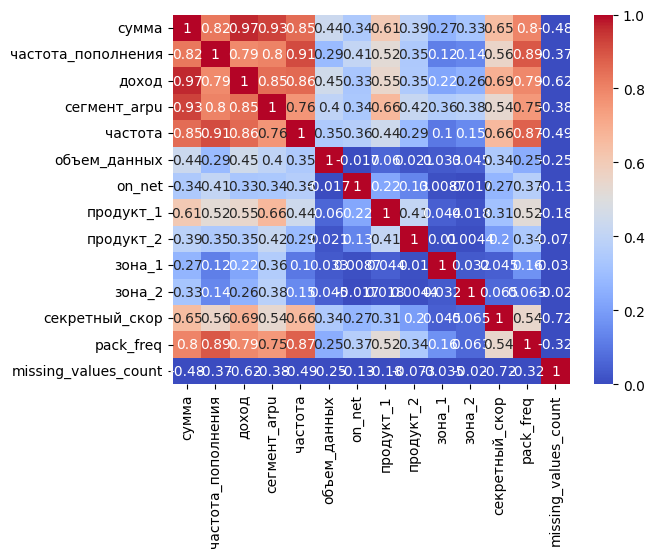

In [ ]:
correlation_matrix = clean_data[num_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)

In [15]:
X = clean_data[feature_cols]
y = clean_data[target_col]

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010248 entries, 0 to 1010247
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   сумма                   655354 non-null   float64
 1   частота_пополнения      655354 non-null   float64
 2   доход                   669787 non-null   float64
 3   сегмент_arpu            669787 non-null   float64
 4   частота                 669787 non-null   float64
 5   объем_данных            512886 non-null   float64
 6   on_net                  641315 non-null   float64
 7   продукт_1               590287 non-null   float64
 8   продукт_2               405005 non-null   float64
 9   зона_1                  79807 non-null    float64
 10  зона_2                  64000 non-null    float64
 11  секретный_скор          1010248 non-null  float64
 12  pack_freq               586973 non-null   float64
 13  missing_values_count    1010248 non-null  int64  
 14  ре

## Построение моделей

In [23]:
def find_optimal_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0, 1, 100)  # Генерируем 100 равномерно распределенных порогов от 0 до 1
    best_threshold = None
    best_f1 = -1

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)  # Преобразуем вероятности в бинарные предсказания по порогу
        f1 = f1_score(y_true, y_pred)  # Вычисляем F1-меру для текущего порога

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1



### LightGBM

In [ ]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    
    model_lgbm_full = LGBMClassifier(**param)

    mapper = DataFrameMapper(
      [([cat_column], [LabelEncoder()]) for cat_column in cat_cols] +
      [([cont_column], None) for cont_column in num_cols]
    )

    pipeline_model_lgbm_full = Pipeline([
      ("mapper", mapper),
      ("classifier", model_lgbm_full)
    ])

    lgbm_classifier_full = pipeline_model_lgbm_full.fit(train_x, train_y)

    preds = lgbm_classifier_full.predict(valid_x)
    
    f1 = f1_score(preds, valid_y)
    
    return f1

In [89]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

[I 2024-04-09 18:30:48,352] A new study created in memory with name: no-name-78d6f367-9b03-4c77-b822-8efad2d72dc7
[I 2024-04-09 18:33:27,024] Trial 0 finished with value: 0.6078386431354573 and parameters: {'booster': 'dart', 'lambda': 0.0004964965369231787, 'alpha': 0.00045137812301332517, 'subsample': 0.4395850919615419, 'colsample_bytree': 0.5312133106591853}. Best is trial 0 with value: 0.6078386431354573.
[I 2024-04-09 18:33:53,523] Trial 1 finished with value: 0.6071315962966147 and parameters: {'booster': 'gbtree', 'lambda': 9.583306594572427e-08, 'alpha': 0.00010782645976483842, 'subsample': 0.8167396144057448, 'colsample_bytree': 0.27922347960961713}. Best is trial 0 with value: 0.6078386431354573.
[I 2024-04-09 18:36:09,377] Trial 2 finished with value: 0.6068194842406878 and parameters: {'booster': 'dart', 'lambda': 2.0435804324332463e-06, 'alpha': 5.98414967797947e-08, 'subsample': 0.3169151149548939, 'colsample_bytree': 0.23928205545346604}. Best is trial 0 with value: 0.6

In [90]:
print("Best trial:")
trial = study.best_trial 

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.6078501465646672
  Params: 
    booster: dart
    lambda: 5.505947819297863e-08
    alpha: 0.05516382844236534
    subsample: 0.3007234025925322
    colsample_bytree: 0.5406218842645367


In [91]:
model_lgbm = LGBMClassifier(**trial.params)

train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

mapper = DataFrameMapper(
  [([cat_column], [LabelEncoder()]) for cat_column in cat_cols] +
  [([cont_column], None) for cont_column in num_cols]
)


pipeline_model_lgbm = Pipeline([
  ("mapper", mapper),
  ("classifier", model_lgbm)
])

lgbm_classifier = pipeline_model_lgbm.fit(train_x, train_y)

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] lambda_l2 is set with lambda=5.505947819297863e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.505947819297863e-08
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] lambda_l2 is set with lambda=5.505947819297863e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.505947819297863e-08
[LightGBM] [Info] Number of positive: 151428, number of negative: 656770
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2499
[LightGBM] [Info] Number of data points in the train set: 808198, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187365 -> initscore=-1.467224
[LightGBM] [Info] Start training from score -1.467224


In [93]:
f1_score(lgbm_classifier.predict(X), y)

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] lambda_l2 is set with lambda=5.505947819297863e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.505947819297863e-08


0.6081055640674373

In [94]:
optimal_threshold_lgbm, max_f1_lgbm = find_optimal_threshold(y, lgbm_classifier.predict_proba(X)[:,1])

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] lambda_l2 is set with lambda=5.505947819297863e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.505947819297863e-08


In [96]:
max_f1_lgbm

0.65319837461158

In [97]:
f1_score((lgbm_classifier.predict_proba(valid_x)[:,1] >= optimal_threshold_lgbm).astype(int), valid_y)

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] lambda_l2 is set with lambda=5.505947819297863e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.505947819297863e-08


0.6512431887906955

In [ ]:
test_clean = data_prepare(df_test)
X_test = test_clean[feature_cols]

In [99]:
submission = pd.read_csv('/kaggle/input/mts-teta-compet1/sample_submission.csv')
submission["preds"] = lgbm_classifier.predict_proba(X_test)[:,1]
submission["preds"] = submission["preds"].apply(lambda x: 1 if x > optimal_threshold_lgbm else 0)
submission.to_csv("/kaggle/working/LightGBM_optuna.csv", index=False)

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] lambda_l2 is set with lambda=5.505947819297863e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.505947819297863e-08


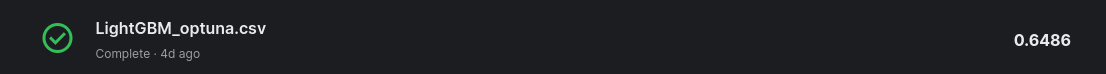

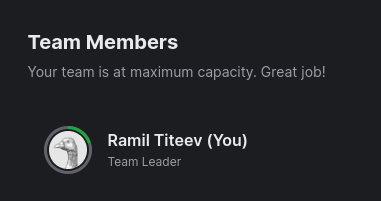